In [2]:
from itertools import permutations, product

import functools

import tqdm

import pandas as pd

from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.model_selection import RepeatedStratifiedKFold, train_test_split, cross_val_score
from sklearn.metrics import accuracy_score, auc, confusion_matrix, balanced_accuracy_score, precision_recall_curve, auc, roc_curve, roc_auc_score
from sklearn.inspection import permutation_importance

from imblearn.ensemble import BalancedBaggingClassifier
from xgboost import XGBClassifier

import numpy as np
from numpy import mean,std

import pickle

from os import path

import matplotlib.pyplot as plt

from warnings import simplefilter
from collections import OrderedDict

simplefilter(action="ignore", category=pd.errors.PerformanceWarning)
simplefilter(action='ignore', category=FutureWarning)



In [10]:
df = pd.read_csv('virus_genome/human_infecting_virus', delimiter='\t', header=None)
df[['ID', 'DNA Sequence']] = df[0].str.split(expand=True)
df = df.drop(0, axis=1)
df['isZoonotic'] = 1


df2 = pd.read_csv('virus_genome/Other_viruses', delimiter='\t', header=None)
df2[['ID', 'DNA Sequence']] = df2[0].str.split(expand=True)
df2 = df2.drop(0, axis=1)
df2['isZoonotic'] = 0

# make both have the same amount of samples..?

# thresh = len(df)
# df2.drop(df2.index[thresh:len(df2.index)], inplace=True)

dfother = pd.DataFrame()
it = len(df)

# iterate through each sequence
for i in range(len(df2)):
    dfother.at[it, 'DNA Sequence']=df2.at[i, 'DNA Sequence']
    dfother.at[it, 'isZoonotic']=int(0)
    dfother.at[it, 'ID']=df2.at[i, 'ID']
    it+=1


df.reset_index(drop=True, inplace=True)
df2.reset_index(drop=True, inplace=True)

mergedDf = pd.concat([df, dfother], axis=0)

In [11]:
print(len(mergedDf))

9430


In [13]:
asdfX = pd.DataFrame()
asdfY = pd.DataFrame()

In [14]:

def resetkmerdict(permset)->OrderedDict:
        kmerdict = OrderedDict()
        for i in permset:
            kmerdict[i]=0
        return kmerdict

def assign_kmers_to_dict(row, permset, kmer):
    kmerdict=resetkmerdict(permset)
    st = row[2] # tune for which column the sequence is in
    for j in range(len(st)-kmer+1):
        if not st[j:j+kmer] in permset: continue
        kmerdict[st[j:j+kmer]]+=1
    return kmerdict

def getTrainParams(mergedDf):
    kmer = 4
    print(mergedDf)
    s = product('acgt',repeat = kmer)
    permset = set(["".join(x) for x in list(s)])

    l = []
    
    for row in tqdm.tqdm(mergedDf.itertuples()):
        l.append(assign_kmers_to_dict(row, permset, kmer))

    finalkmerdict=pd.DataFrame(l)
    # mergedDf.fillna(0, inplace=True)

    X = finalkmerdict
    Y = mergedDf['isZoonotic']
    X = X.apply(lambda x: (x-x.min())/(x.max()-x.min()), axis=1)
    print(X.head())
    
    # print(len(X))
    # print(len(Y))

    global asdfX
    asdfX = X.copy()
    global asdfY
    asdfY = Y.copy()


    place = pd.concat([X, Y], axis=1)
    
    print(place)

    place.to_csv('info.csv', index=False)
    print("TRUTH")
    print(place[place.isna().any(axis=1)])

    return train_test_split(X, Y, test_size=0.2, random_state=1)

In [7]:
for x in mergedDf['isZoonotic'].isna():
    x and print(x)

In [15]:
X_train, X_test, y_train, y_test = getTrainParams(mergedDf)

zz = X_train.head()


           ID                                       DNA Sequence  isZoonotic
0       37121  cttttaacaatcatagttttataaaagggtgtaaccgaagcggttt...         1.0
1       37121  cttttaacaatcatagttttataaaagggtgtaaccgaagcggttt...         1.0
2       37121  cttttaacaatcatagttttataaaagggtgtaaccgaagcggttt...         1.0
3      129724  atactttacaattatcttgtaaaaagtagggtgtaaccgaaaaggg...         1.0
4       59303  atggcggacgtgtgacatcaccgttcgctctttctaggatcctttg...         1.0
...       ...                                                ...         ...
9425   268315  ggatccacagaactccttgtatgtacagccgcgggtacccacagca...         0.0
9426   130329  ctcatgtcattaataagaccatgcagaaaatgcaaatgaggcgaag...         0.0
9427  1239437  ccgaagtgggatggcggctgccgccgcttcggcgcttggcgcttcg...         0.0
9428   358812  gtatacgaggttagttcattctcgtatacacgattggacaaatcaa...         0.0
9429    11287  atggaaggaggaattcgtgcagcgttttcaggcctgaatgatgtta...         0.0

[9430 rows x 3 columns]


9430it [01:39, 94.81it/s] 


       cctg      gtgt      acac      ccga      ttga      accg      ctca  \
0  0.297872  0.819149  0.446809  0.074468  0.265957  0.063830  0.106383   
1  0.297872  0.819149  0.446809  0.074468  0.265957  0.063830  0.106383   
2  0.297872  0.819149  0.446809  0.074468  0.265957  0.063830  0.106383   
3  0.367347  0.857143  0.469388  0.040816  0.295918  0.081633  0.081633   
4  0.483871  0.451613  0.580645  0.494624  0.311828  0.677419  0.129032   

       tgtt      agcc      cgtt  ...      tggg      aata      tatg      gatc  \
0  0.712766  0.095745  0.085106  ...  0.372340  0.702128  0.617021  0.095745   
1  0.712766  0.095745  0.085106  ...  0.372340  0.702128  0.617021  0.095745   
2  0.712766  0.095745  0.085106  ...  0.372340  0.702128  0.617021  0.095745   
3  0.806122  0.214286  0.102041  ...  0.285714  0.581633  0.744898  0.051020   
4  0.204301  0.365591  0.129032  ...  0.204301  0.161290  0.161290  0.311828   

       ttac      ggga      ggtc      atac      atta      ccgc  
0  0

In [21]:
lrmodel = LogisticRegression(
    multi_class="multinomial", max_iter=1000,
    fit_intercept=False, tol=0.001, solver='saga', random_state=42)
lrmodel.fit(X_train, y_train)

LogisticRegression(fit_intercept=False, max_iter=1000,
                   multi_class='multinomial', random_state=42, solver='saga',
                   tol=0.001)

In [22]:
# all 0s for some reason
print(X_test[:10])
predictions = lrmodel.predict(X_test)
print(accuracy_score(y_test, predictions))

          cctg      gtgt      acac      ccga      ttga      accg      ctca  \
7555  0.732143  0.357143  0.696429  0.482143  0.892857  0.375000  0.839286   
3005  0.112245  0.367347  0.602041  0.214286  0.561224  0.183673  0.479592   
5636  0.029666  0.137206  0.201483  0.061805  0.380717  0.072930  0.114957   
8800  0.048193  0.156627  0.506024  0.144578  0.373494  0.192771  0.156627   
3832  0.078431  0.377451  0.122549  0.151961  0.411765  0.122549  0.210784   
1297  0.155431  0.170412  0.099251  0.024345  0.378277  0.039326  0.102996   
3304  0.285714  0.392857  0.285714  0.142857  0.607143  0.107143  0.107143   
4977  0.370370  0.407407  0.470899  0.089947  0.592593  0.158730  0.629630   
8281  0.904000  0.608000  0.424000  0.608000  0.136000  0.592000  0.440000   
2947  0.299553  0.189270  0.175857  0.582712  0.245902  0.351714  0.223547   

          tgtt      agcc      cgtt  ...      tggg      aata      tatg  \
7555  0.571429  0.500000  0.214286  ...  0.696429  0.160714  0.39285

[ 0.05111878  0.68588106 -0.37934866 -1.0025827  -0.47984785  0.07477533
 -0.58451518  0.3854648   0.05092851  0.07978889  0.91971549  0.27988209
  0.34029752 -0.13400676  0.07849638 -0.08514907  0.04406175 -0.49096057
  0.16474512 -0.59343923 -0.01965866 -0.17820067 -0.35436524  0.39228988
  0.3296067  -0.37285436 -0.0765294  -0.23979368  0.41046027  0.02390315
  0.16718733  0.4499509   0.43811264 -1.09908662 -1.10011192  0.28518037
  0.2998044  -0.2754323   0.76155611 -0.05125308  0.27602497 -0.65899298
 -0.08888375  0.49976565 -0.12079416 -0.29791872 -0.21557509 -0.1540932
 -0.33084827 -0.5296906   0.28585361  0.28527873  0.22063543  0.36831242
  0.60566516  0.10016101 -0.07248715  0.59942893 -0.06164969 -0.12895664
  0.18782043  0.50124692  0.08387745 -0.5544527  -0.03731634  1.02552241
 -0.62982019 -0.5642888  -0.44852577 -1.01437449 -0.20489381 -0.27801471
  0.21287899 -1.00773061  0.33329683  1.01895143  0.35090056 -0.56800666
 -0.38139804 -0.21228479 -0.0545633   0.39707508  0.

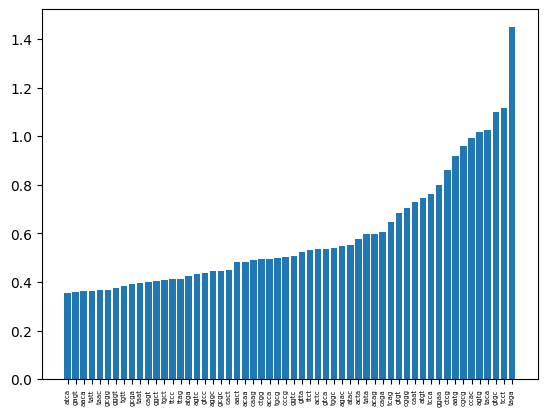

In [23]:
results = lrmodel.coef_[0]
print(results)

l = zip([x for x in X_test.columns.values],results)
l = list(l)
res = sorted(l, key= lambda x: x[1])

plt.xticks(rotation=90)
plt.tick_params(axis='x', which='major', labelsize=5)

plt.bar([x[0] for x in res[200:]], [x[1] for x in res[200:]])
plt.show()